In [1]:
import os
import glob
import time
import joblib


import tensorflow as tf
import pandas as pd
import numpy as np
import json
from datetime import datetime


import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from skimage.color import rgb2gray

from glob import glob
from datetime import datetime
import subprocess
from tqdm import tqdm
from pprint import pprint


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import load_model


from nntool import unet

In [2]:
"""
https://www.youtube.com/watch?v=Gl-N3xr5zLI
Add min_delta, period

tf.train.latest_checkpoint

try increasing bottleneck 
it has more generality


"""

input_params = {
    
    # model training parameters 

    "depth" : 4,
    "batch_size" : 4,
    "epochs" : 100,
    "SEED" : np.random.randint(1000,7000),
    "IMG_HEIGHT" : 224, # <- 
    "IMG_WIDTH" : 224,
    "input_channels" : 1,
    "steps_per_epoch" : 10,# (64115 // batch_size) 
    "validation_steps" : 10,# (2693 // batch_size)
    "learning_rate" : 1e-3,
    "use_multiprocessing" : True,
    "shuffle" : True,
    "patience":10,

    # verbose parameters
    "disp_gpu" : 'n',
    "TF_CPP_MIN_LOG_LEVEL":'2',

    # data generator parameters
    "rotation_range":45,
    "horizontal_flip":True,
    "vertical_flip":False,
    "fill_mode": "nearest",
    "width_shift_range" : 0.2,
    "height_shift_range" : 0.2,
    "shear_range" : 0.2,
    "zoom_range" : 0.2,
    "rescale" :1./255,
    
    
    # standardization works on numpy data only we need to fit data look for this 
    "featurewise_center":False,
    "featurewise_std_normalization":False,
    "samplewise_center" : True,
    "samplewise_std_normalisation" : True,
    
    # save and load model weights/checkpoint ?
    "save_h5":'y',
    "save_ckpt":'n',
    
    
    "load_h5" : 'y',
    "load_ckpt": 'n'
}

In [3]:
SEED = 3017 
IMG_HEIGHT = input_params['IMG_HEIGHT']
IMG_WIDTH = input_params['IMG_WIDTH']
input_image_channels = 1

if input_image_channels == 3:
    color_mode='rgb'
if input_image_channels == 1:
    color_mode='grayscale'
    

# Model Loading

In [4]:
print("#"*40)
print("\nCreated UNet ...\n")


model = unet.custom_unet(depth=input_params['depth'], input_shape=(
        IMG_HEIGHT, IMG_WIDTH, input_image_channels), verbose=False)
lr = input_params['learning_rate']

# print("learning_rate = ", lr, "depth = ", input_params['depth'] ,"\n")

for i in (input_params.keys()):
    if i == "rotation_range":
        break
    
    print("{0:<20s} : ".format(i),"{0:<10}".format(str(input_params[i])))

print()
print("#"*40)
print()
# ans = input("Do you want to load trained model [y/n] ")

if input_params['load_h5'] == 'y':
    print("Choose Models dir ...\n")
    l = list(sorted(glob("./logs/models/*")))
    pprint(list(enumerate(sorted(glob("./logs/models/*")))))

    _ = int(input("Enter folder number -> "))

    p = l[_]
    l = sorted(glob(p+"/*"))
    pprint(list(enumerate(sorted(glob(p+"/*")))))
    _ = int(input("Enter file number -> "))
    req_p = l[_]
    print(req_p)

    model = load_model(req_p, compile=False)
    model.compile(optimizer=Adam(lr=lr), loss=unet.dice_coef_loss,
                                metrics=[unet.dice_coef, unet.iou])
    
elif input_params['load_ckpt'] == 'y':
    print("Choose Checkpoint dir ...\n")
    l = list(sorted(glob("./logs/models/*")))
    pprint(list(enumerate(sorted(glob("./logs/models/*")))))

    _ = int(input("Enter folder number -> "))

    p = l[_]
    l = sorted(glob(p+"/*"))
    pprint(list(enumerate(sorted(glob(p+"/*")))))
    _ = int(input("Enter file number -> "))
    req_p = l[_]
    print(req_p)

    model = load_model(req_p, compile=False)
    model.compile(optimizer=Adam(lr=lr), loss=unet.dice_coef_loss,
                                metrics=[unet.dice_coef, unet.iou])
    
else:
    model.compile(optimizer=Adam(lr=lr), loss=unet.dice_coef_loss,
                                    metrics=[unet.dice_coef, unet.iou])

########################################

Created UNet ...

depth                :  4         
batch_size           :  4         
epochs               :  100       
SEED                 :  1276      
IMG_HEIGHT           :  224       
IMG_WIDTH            :  224       
input_channels       :  1         
steps_per_epoch      :  10        
validation_steps     :  10        
learning_rate        :  0.001     
use_multiprocessing  :  True      
shuffle              :  True      
patience             :  10        
disp_gpu             :  n         
TF_CPP_MIN_LOG_LEVEL :  2         

########################################

Choose Models dir ...

[(0, './logs/models/191122-154348_3U'),
 (1, './logs/models/191125-140339_3U'),
 (2, './logs/models/191125-154602_4U'),
 (3, './logs/models/191125-181011_5U'),
 (4, './logs/models/191126-004044_5U'),
 (5, './logs/models/191126-135547_5U'),
 (6, './logs/models/191128-020527_4U_best_so_far'),
 (7, './logs/models/224x224_trained_5050')]
Enter folder 

# Image load and testing 

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL']=input_params['TF_CPP_MIN_LOG_LEVEL']


# In[2]:

# _ = input("Display device and gpu details [y/n] ")
_ = input_params['disp_gpu']
if _ == 'y':
        print(device_lib.list_local_devices())
else:
        pass


# # Directory Structure

# In[3]:

"""
print()
os.system("tree ../data/coco-person/ --dirsfirst --filelimit 10")
print()
print("#"*40)
"""

# # Get Data ids

# In[4]:


def get_data_ids():
        train_imgs = []
        train_masks = []

        val_imgs = []
        val_masks = []

        common_path = "../data/coco-person/"
        paths = [
                "train/person_images/images/*", "train/person_masks/masks/*",
                "val/person_images/images/*", "val/person_masks/masks/*"]
        # final list var will have => [train_imgs, train_masks, val_imgs, val_masks]

        var = []

        for i in paths:
                # print(os.path.join(common_path,i))
                var.append(glob(os.path.join(common_path, i)))

        return var


train_imgs_dir = "../data/coco-person/train/person_images/"
train_masks_dir = "../data/coco-person/train/person_masks/"

val_imgs_dir = "../data/coco-person/val/person_images/"
val_masks_dir = "../data/coco-person/val/person_masks/"


X_train, y_train, X_test, y_test = get_data_ids()


# In[5]:


# print("total training person images {" ":>10}".format(len(X_train)))
# print("total training person masks {" ":>11}".format(len(y_train)))

# print("total validation person images {" ":>8}".format(len(X_test)))
# print("total validation person masks {" ":>9}".format(len(y_test)))


# # Parameters

# In[6]:
"""
print("#"*40)
print("\nSetting Parameters ...\n")
print("#"*40)
"""
depth = input_params['depth']
batch_size = input_params['batch_size']
epochs = input_params['epochs']


SEED = input_params['SEED']
IMG_HEIGHT = input_params['IMG_HEIGHT']
IMG_WIDTH = input_params['IMG_WIDTH']
input_image_channels = input_params['input_channels']

if input_image_channels == 3:
        color_mode = 'rgb'
if input_image_channels == 1:
        color_mode = 'grayscale'

# this will do batch training
steps_per_epoch_full = (len(X_train) // batch_size)
validation_steps_full = (len(X_test) // batch_size)

"""
print("#"*40)
print("\nTraining Steps per epoch to cover all dataset are {}".format(
        steps_per_epoch_full))
print("Validation Steps per epoch to cover all dataset are {}".format(
        validation_steps_full),"\n")

"""
# as we are augmenting dataset
# and our dataset is very huge
# we need mini batches

steps_per_epoch = input_params['steps_per_epoch']
validation_steps = input_params['validation_steps']

"""
print("\nSetting steps_per_epoch to {}".format(steps_per_epoch))
print("Setting validation_steps to {}".format(validation_steps),"\n")

print("_"*40,"\n")
"""
# In[ ]:


# # Image Data Generator

# In[7]:


image_datagen = ImageDataGenerator(
        rotation_range=input_params['rotation_range'],
        horizontal_flip=input_params['horizontal_flip'],
        vertical_flip=input_params['vertical_flip'],
        fill_mode=input_params['fill_mode'],
        width_shift_range=input_params['width_shift_range'],
        height_shift_range=input_params['height_shift_range'],
        shear_range=input_params['shear_range'],
        zoom_range=input_params['zoom_range'],
        rescale=input_params['rescale'],
        # featurewise_center=input_params['featurewise_center'],
        # featurewise_std_normalization=['featurewise_std_normalization'],
        samplewise_center=input_params['samplewise_center'],
        samplewise_std_normalization=['samplewise_std_normalization'],
)


mask_datagen = ImageDataGenerator(
        rotation_range=input_params['rotation_range'],
        horizontal_flip=input_params['horizontal_flip'],
        vertical_flip=input_params['vertical_flip'],
        fill_mode=input_params['fill_mode'],
        width_shift_range=input_params['width_shift_range'],
        height_shift_range=input_params['height_shift_range'],
        shear_range=input_params['shear_range'],
        zoom_range=input_params['zoom_range'],
        rescale=input_params['rescale'],
        # featurewise_center=input_params['featurewise_center'],
        # featurewise_std_normalization=['featurewise_std_normalization'],
        samplewise_center=input_params['samplewise_center'],
        samplewise_std_normalization=['samplewise_std_normalization'],
)


# # Flow from directory

# ## train generators

# In[8]:


train_img_generator = image_datagen.flow_from_directory(batch_size=batch_size,
                                                        directory=train_imgs_dir,
                                                        shuffle=True,
                                                        target_size=(
                                                            IMG_HEIGHT, IMG_WIDTH),
                                                        class_mode=None,
                                                        color_mode=color_mode,
                                                        seed=SEED)


train_mask_generator = image_datagen.flow_from_directory(batch_size=batch_size,
                                                         directory=train_masks_dir,
                                                         shuffle=True,
                                                         target_size=(
                                                                 IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode=None,
                                                         color_mode='grayscale',
                                                         seed=SEED)


# ## validation generators

# In[9]:


val_img_generator = image_datagen.flow_from_directory(batch_size=batch_size,
                                                    directory=val_imgs_dir,
                                                    shuffle=True,
                                                    target_size=(
                                                            IMG_HEIGHT, IMG_WIDTH),
                                                    class_mode=None,
                                                    color_mode=color_mode,
                                                    seed=SEED)


val_mask_generator = image_datagen.flow_from_directory(batch_size=batch_size,
                                                     directory=val_masks_dir,
                                                     shuffle=True,
                                                     target_size=(
                                                             IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode=None,
                                                     color_mode='grayscale',
                                                     seed=SEED)

val_generator = zip(val_img_generator, val_mask_generator)


# In[10]:


def image_mask_generator(image_data_generator, mask_data_generator):
        train_generator = zip(image_data_generator, mask_data_generator)
        for (img, mask) in train_generator:

            yield (img, mask)

            
train_generator = image_mask_generator(
        train_img_generator, train_mask_generator)
val_generator = image_mask_generator(val_img_generator, val_mask_generator)
"""
print()
print("_"*40)
print()

print("#"*40)
print("#"*40)
print("Data Generators Set ...")
print("#"*40)
"""
0

Found 64115 images belonging to 1 classes.
Found 64115 images belonging to 1 classes.
Found 2693 images belonging to 1 classes.
Found 2693 images belonging to 1 classes.


0

In [6]:
DATA_DIR = "../data/coco-person/"

train_IMG_DIR = "../data/coco-person/train/person_images/images/"
train_MAS_DIR = "../data/coco-person/train/person_masks/masks/"

val_IMG_DIR = "../data/coco-person/val/person_images/images/"
val_MAS_DIR = "../data/coco-person/val/person_masks/masks/"


train_img_list = glob(train_IMG_DIR+"*")
train_mas_list = glob(train_MAS_DIR+"*")

val_img_list = glob(val_IMG_DIR+"*")
val_mas_list = glob(val_MAS_DIR+"*")

path_list = [train_img_list, train_mas_list, val_img_list, val_mas_list]

In [7]:
final_dict = {
    # only one id is enough to get paths
    "train":{
        "image":{},
        "mask":{}
    },
    "val":{
        "image":{},
        "mask":{}
    }
}

for i,j in zip(train_img_list,train_mas_list):
    final_dict["train"]['image'][os.path.basename(i).replace(".jpg","")] = i
    final_dict["train"]['mask'][os.path.basename(j).replace(".png","")] = j
    
for i,j in zip(val_img_list,val_mas_list):
    final_dict["val"]['image'][os.path.basename(i).replace(".jpg","")] = i
    final_dict["val"]['mask'][os.path.basename(j).replace(".png","")] = j


In [8]:
# final_dict["val"]["image"].keys()

In [9]:
def get_reqd_paths(ids,check_dict,check="train"):
    im_paths = []
    ma_paths = []
    
    if check == "train":
        for i in ids:
            im_paths.append(check_dict["train"]["image"][i])
            ma_paths.append(check_dict["train"]["mask"][i])
    
    if check == "val":
        for i in ids:
            im_paths.append(check_dict["val"]["image"][i])
            ma_paths.append(check_dict["val"]["mask"][i])
    
    return im_paths,ma_paths
            
ids = [
    '516038', '429690', '59635', '160864', '246963', '422998', '277005', '519688', '292024', '507667', '273493', '530854', '346968', '24021', '165681', '12670', '572462', '490936', '494188', '286523', '230008', '69224', '471756', '2431'
]


(im_paths,ma_paths) = get_reqd_paths(ids,final_dict,check="val")

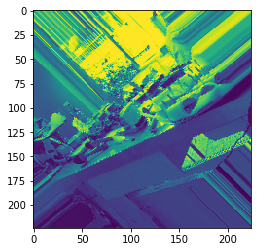

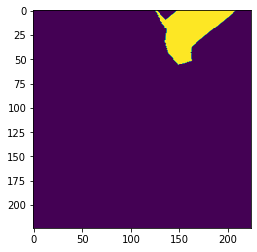

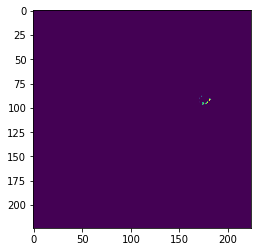

2302


<tf.Tensor: id=25747, shape=(), dtype=float32, numpy=0.00043523542>

In [144]:


t = next(val_generator)

plt.imshow(np.squeeze(t[0][1]))
plt.show()
plt.imshow(np.squeeze(t[1][1]))
plt.show()
plt.imshow(np.squeeze(model.predict(np.array([t[0][1]]))))
plt.show()
pred = np.squeeze(model.predict(np.array([t[0][1]])))
true = np.squeeze(t[1][1])

y_true , y_pred = (true,pred)

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    
    y_true_f = tf.clip_by_value(y_true_f,0,1)
    y_pred_f = tf.clip_by_value(y_pred_f,0,1)
    
    print(np.count_nonzero(y_true_f.numpy()))

    """
    m1 = tf.math.reduce_min(tf.clip_by_value(y_true_f,0,1))
    m2 = tf.math.reduce_min(tf.clip_by_value(y_pred_f,0,1))

    m1_ = tf.math.reduce_max(tf.clip_by_value(y_true_f,0,1))
    m2_ = tf.math.reduce_max(tf.clip_by_value(y_pred_f,0,1))
    
    
    print()
    print("*"*10)
    print("yTRUE min max______\n",m1,m1_)
    print()
    print("yPRED min max______\n",m2,m2_)
    print()
    """

    intersection = K.sum(y_true_f * y_pred_f)

    dc = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    # print("dc______\n",dc)

    return dc


dice_coef(y_true, y_pred)

In [53]:
# t[0][1].mean()

In [54]:
# plt.hist(t[0][1].flatten(),bins=100)